In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from joblib import dump,load
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from scipy.io.arff import loadarff
import os
%matplotlib inline
sns.set_theme()


data_dir = './data/'
model_dir = './model/'
os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
seed = 42

# Functions

## Split Data

In [2]:
def label_encode(data, cat_cols):
    label_encoders = {}
    for col in cat_cols:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])
    return label_encoders

def label_decode(data, encoders):
    for col, encoder in encoders.items():
        data[col] = encoder.inverse_transform(data[col])

# Split data
def split_data(data):
    X = data.drop(['fraud'], axis=1)
    y = data['fraud']
    return train_test_split(X,y,test_size=0.3, random_state=seed, shuffle=True, stratify=y)

## Create Models

In [3]:
def create_models(dataset, X_train, X_test, y_train, y_test, skip_existing=False):
    # TODO different classifiers
    models = {
        'Random Forest': {
            'model': RandomForestClassifier(),
            'params': {
                'random_state': seed
            }
        },
        'XGBoost': {
            'model': XGBClassifier(),
            'params': {
                'objective': 'binary:logistic',
                'random_state': seed,
            }
        },
        # 'SVC linear': {
        #     'model': SVC(),
        #     'params': {
        #         'kernel': 'linear',
        #         'random_state': seed
        #     }
        # },
        # 'SVC poly': {
        #     'model': SVC(),
        #     'params': {
        #         'kernel': 'poly',
        #         'random_state': seed
        #     }
        # },
        'Naive Bayes': {
            'model': GaussianNB(),
            'params': {}
        }
    }

    model_pickles = []
    start_time = time.time()
    for name, info in models.items():
        loop_time = time.time()
        model_pickle_name = f'{model_dir}{dataset}_{name}.joblib'
        if skip_existing and os.path.isfile(model_pickle_name):
            continue

        print(f'Starting {name}')
        # Train Model
        model = info['model'].set_params(**info['params'])
        model.fit(X_train, y_train)

        # Save results to file
        info['y_pred'] = model.predict(X_test)
        dump(info, model_pickle_name)
        model_pickles.append(model_pickle_name)

        end_time = time.time()
        print(f'Training {name}: {end_time-loop_time:.2f} seconds')
    end_time = time.time()
    print(f'Total Training: {end_time-start_time:.2f} seconds')
    return models, model_pickles


## Evaluate

In [18]:
def model_results(dataset, models, X_train, X_test, y_train, y_test, load_from_disk=False):
    # Load Models from disk
    if load_from_disk:
        models = {name: load(f'{model_dir}{dataset}_{name}.joblib') for name in models.keys()}

    # Classification Reports
    reports = {}
    accuracies = {}
    for name,info in models.items():
        reports[name] = classification_report(y_test, info['y_pred'], output_dict=True)
        accuracies[name] = accuracy_score(y_test,info['y_pred'])

    columns = ['Precision (0)', 'Precision (1)', 'Recall (0)', 'Recall (1)', 'F1-Score (0)', 'F1-Score (1)', 'Accuracy']
    rows = list(reports.keys())
    cell_text = []
    for model_name in rows:
        values = [reports[model_name][class_label]['precision'] for class_label in ['0', '1']]
        values += [reports[model_name][class_label]['recall'] for class_label in ['0', '1']]
        values += [reports[model_name][class_label]['f1-score'] for class_label in ['0', '1']]
        values.append(accuracies[model_name])
        cell_text.append(values)
    classification_table = pd.DataFrame(cell_text, index=rows, columns=columns).transpose()

    sns.reset_orig()
    fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(6, 6 * len(models)))
    # Plot confusion matrix for each class
    i = 0
    for name,info in models.items():
        disp = ConfusionMatrixDisplay.from_estimator(info['model'], X_test, y_test, ax=axes[i], cmap='viridis', values_format='.4g', display_labels=['Not Fraud', 'Fraud'])
        disp.ax_.set_title(f'{name}')
        i+=1
    fig.suptitle(f'Confusion Matrix for {dataset}')
    plt.show()
    sns.set_theme()

    # Grouped Results
    ax = plt.gca()
    for name, info in models.items():
        RocCurveDisplay.from_estimator(info['model'], X_test,y_test, ax=ax, alpha=0.8)
    plt.title(f'ROC Curve for all {dataset} models')
    plt.show()

    return classification_table

# Banksim1
## Loading

In [ ]:
# Load Banksim1
bank_trans = pd.read_csv(f'{data_dir}banksim1/bs140513_032310.csv')
bank_network = pd.read_csv(f'{data_dir}banksim1/bsNET140513_032310.csv') # same data but with less columns

In [ ]:
print(f'Bank Transactions {bank_trans.shape}')
bank_trans.head()

Bank Transactions (594643, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [16]:
print(f'Bank Network {bank_network.shape}')
bank_network.head()

Bank Network (594643, 5)


,Source,Target,Weight,typeTrans,fraud
0,'C1093826151','M348934600',4.55,'es_transportation',0
1,'C352968107','M348934600',39.68,'es_transportation',0
2,'C2054744914','M1823072687',26.89,'es_transportation',0
3,'C1760612790','M348934600',17.25,'es_transportation',0
4,'C757503768','M348934600',35.72,'es_transportation',0


## Dataset Visualization Fraud distribution

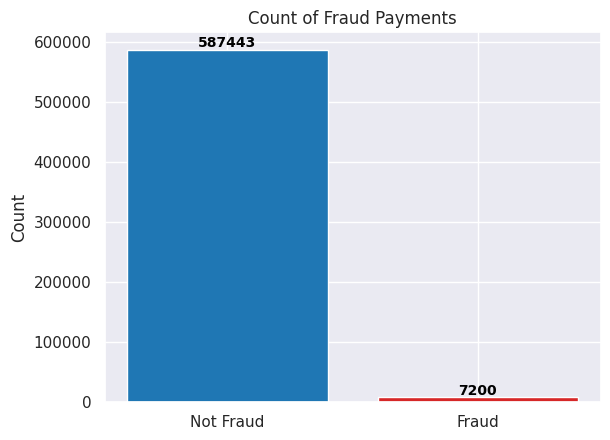

In [ ]:
# Fraud 
fraud = bank_trans.fraud.value_counts()
fig, ax = plt.subplots()
bars = ax.bar(['Not Fraud', 'Fraud'],fraud.values, color=['#1f77b4', '#d62728'])

# Add labels to the top of each bar
ax.bar_label(bars, labels=fraud.values, label_type='edge', color='black', fontsize=10, weight='bold')

# Customize the plot
ax.set_ylabel('Count')
ax.set_title('Count of Fraud Payments')
plt.show()

Text(0.5, 1.0, 'Amount Distribution - Max 8329.96')

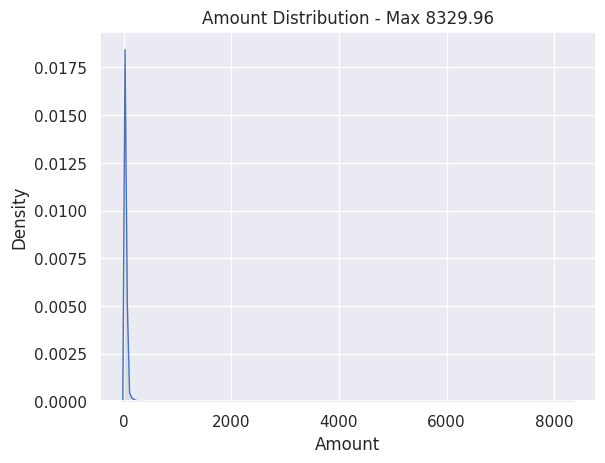

In [ ]:
sns.kdeplot(data=bank_trans, x='amount', fill=True, alpha=0.1, linewidth=1)
plt.xlabel('Amount')
plt.ylabel('Density')
max_amount = max(bank_trans.amount)
plt.title(f'Amount Distribution - Max {max_amount}')

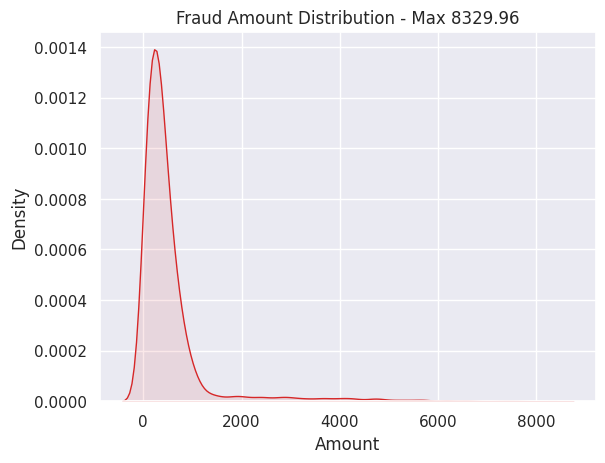

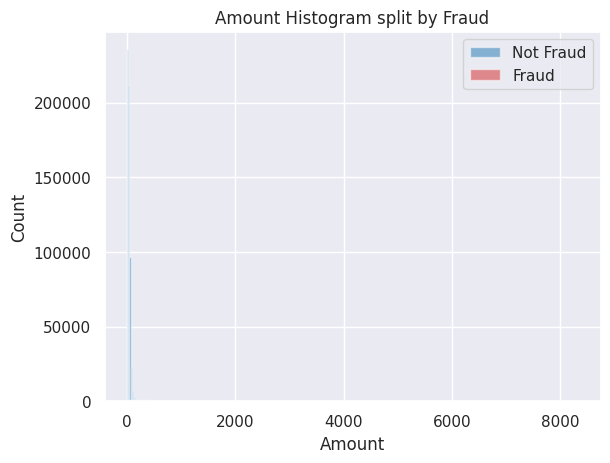

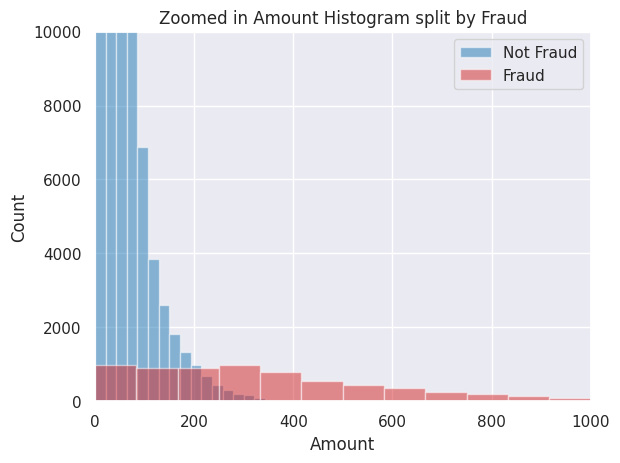

In [ ]:
fraud = bank_trans.loc[bank_trans.fraud == 1]
not_fraud = bank_trans.loc[bank_trans.fraud == 0]

sns.kdeplot(data=fraud, x='amount', fill=True, color='#d62728', alpha=0.1, linewidth=1)
plt.xlabel('Amount')
plt.ylabel('Density')
max_amount = max(fraud.amount)
plt.title(f'Fraud Amount Distribution - Max {max_amount}')
plt.show()

plt.hist(not_fraud.amount, alpha=0.5,label='Not Fraud', bins=100, color='#1f77b4')
plt.hist(fraud.amount, alpha=0.5,label='Fraud', bins=100, color='#d62728')
plt.title('Amount Histogram split by Fraud')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.hist(not_fraud.amount, alpha=0.5,label='Not Fraud', bins=100, color='#1f77b4')
plt.hist(fraud.amount, alpha=0.5,label='Fraud', bins=100, color='#d62728')
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.title('Zoomed in Amount Histogram split by Fraud')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.legend()
plt.show()



In [39]:
dataset = 'banksim1' # TODO multiple datasets
# Load Data
# Display Data 
## DIFFERENT FOR EACH DATASET

In [40]:
# Clean up data
## DIFFERENT FOR EACH DATASET
data = bank_trans
print(data.nunique())
data = data.drop(['zipcodeOri', 'zipMerchant'],axis=1) # drop single value columns
data.age = pd.to_numeric(data.age.str.strip("'"), errors='coerce').fillna(-1).astype(int) # convert age to numbers, U's turn into -1's
cat_cols = ['customer', 'gender', 'merchant', 'category']
label_encoders = label_encode(data, cat_cols)


step             180
customer        4112
age                8
gender             4
zipcodeOri         1
merchant          50
zipMerchant        1
category          15
amount         23767
fraud              2
dtype: int64


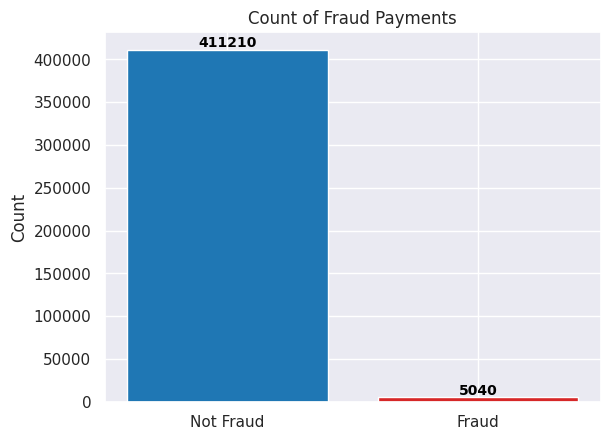

In [53]:
# Train Data
## Should be same for each
# X_train, X_test, y_train, y_test = split_data(data)
_data = split_data(data) # so good with names
models, model_pickles = create_models(dataset, *_data, skip_existing=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       0.89      0.73      0.80      2160

    accuracy                           1.00    178393
   macro avg       0.94      0.87      0.90    178393
weighted avg       1.00      1.00      1.00    178393



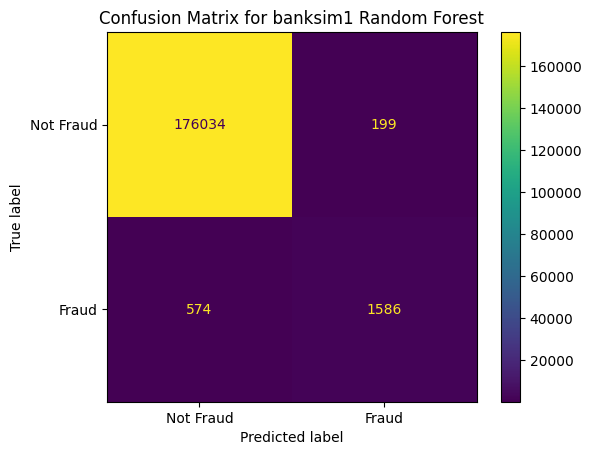

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       0.88      0.77      0.82      2160

    accuracy                           1.00    178393
   macro avg       0.94      0.89      0.91    178393
weighted avg       1.00      1.00      1.00    178393



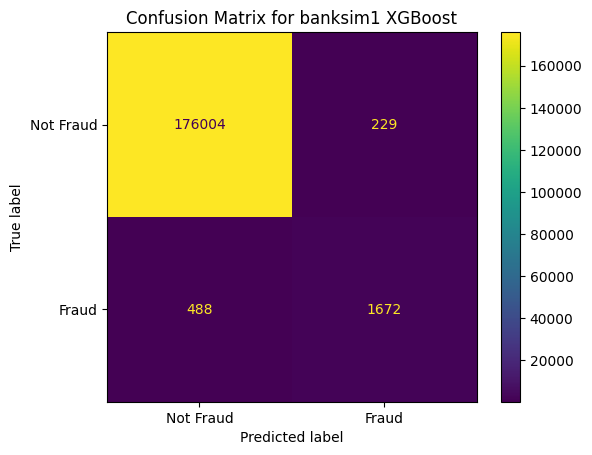

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    176233
           1       0.78      0.58      0.66      2160

    accuracy                           0.99    178393
   macro avg       0.89      0.79      0.83    178393
weighted avg       0.99      0.99      0.99    178393



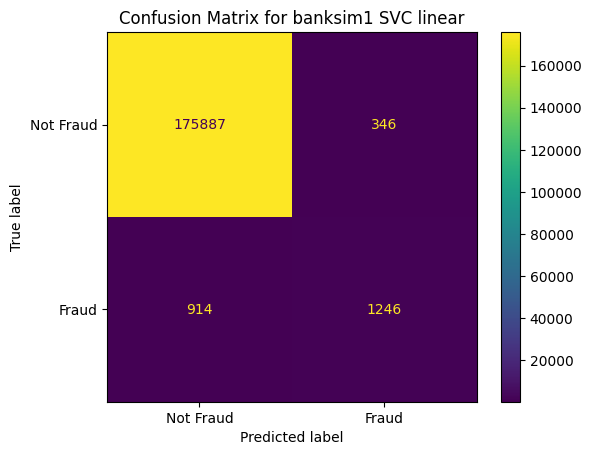

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    176233
           1       0.95      0.36      0.52      2160

    accuracy                           0.99    178393
   macro avg       0.97      0.68      0.76    178393
weighted avg       0.99      0.99      0.99    178393



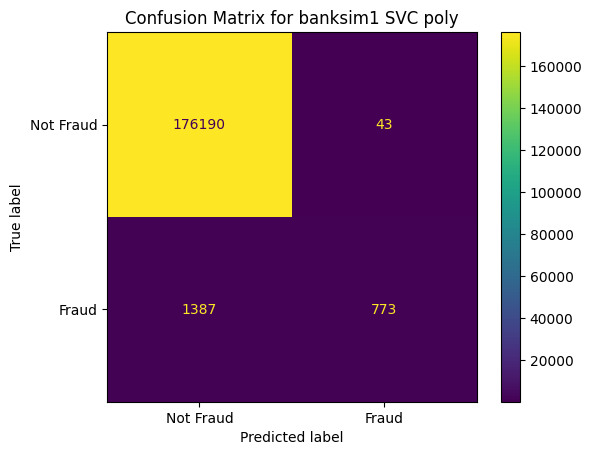

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.41      0.77      0.54      2160

    accuracy                           0.98    178393
   macro avg       0.70      0.88      0.77    178393
weighted avg       0.99      0.98      0.99    178393



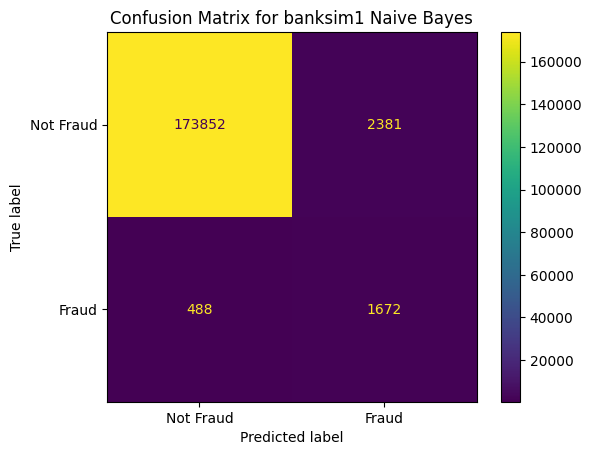

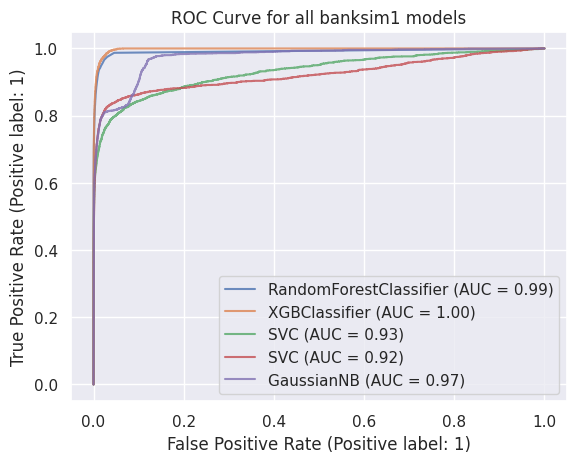

In [48]:
# Display
model_results(dataset, models, *_data, load_from_disk=True)

# TODO Comparing Models and Datasets

# Paysim1

In [5]:
dataset = 'paysim1' # TODO multiple datasets
# Load Data
paysim = pd.read_csv(f'{data_dir}paysim1/PS_20174392719_1491204439457_log.csv')
# Display Data 
## TODO DIFFERENT FOR EACH DATASET

In [6]:

# Clean up data
data = paysim.rename(columns={'isFraud': 'fraud'})
print(data.nunique())
cat_cols = ['type','nameOrig', 'nameDest']
label_encoders = label_encode(data, cat_cols)
data.dtypes

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
fraud                   2
isFlaggedFraud          2
dtype: int64


step                int64
type                int64
amount            float64
nameOrig            int64
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest            int64
oldbalanceDest    float64
newbalanceDest    float64
fraud               int64
isFlaggedFraud      int64
dtype: object

In [7]:
# Train Data
## Should be same for each
# X_train, X_test, y_train, y_test = split_data(data)
_data = split_data(data) # so good with names
models, model_pickles = create_models(dataset, *_data, skip_existing=True)

Training Naive Bayes: 3.31 seconds
Total Training: 3.32 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.88      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



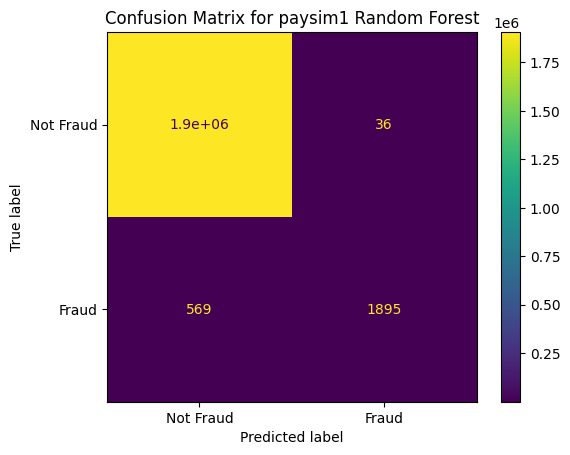

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      0.84      0.90      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.92      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



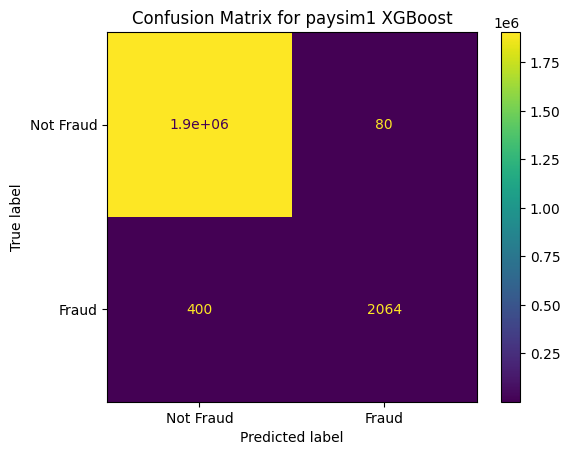

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906322
           1       0.03      0.17      0.05      2464

    accuracy                           0.99   1908786
   macro avg       0.51      0.58      0.52   1908786
weighted avg       1.00      0.99      0.99   1908786



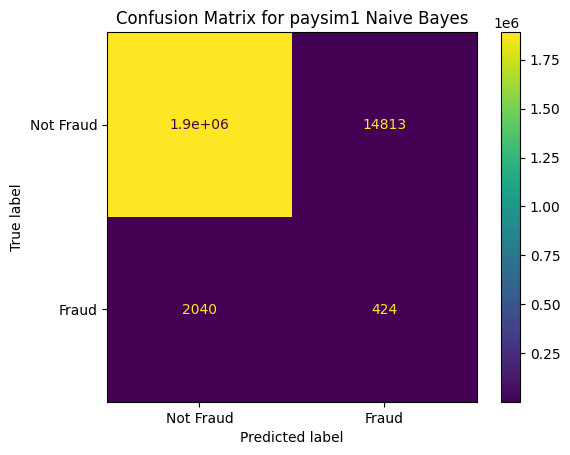

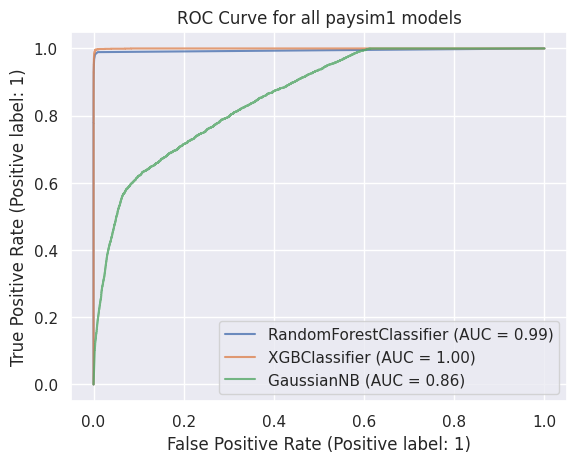

In [9]:

# Display
model_results(dataset, models, *_data, load_from_disk=True)

# TODO Comparing Models and Datasets

# 2013 European Credit Card Fruad Dataset

In [5]:
dataset = '2013_euro_creditcard'
# Load dataset
arff = loadarff(f'{data_dir}2013_credit_card/September 2013 by european cardholders.arff')
cardholders = pd.DataFrame(arff[0])
print(f'Cardholders Transactions {cardholders.shape}')
# convert Class to int
cardholders.Class = cardholders.Class.str.decode('utf-8').astype(int)
cardholders = cardholders.rename(columns={'Class': 'fraud', 'Amount': 'amount'})
cardholders.head()

data = cardholders
print(data.nunique())

Cardholders Transactions (284807, 31)
Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
amount     32767
fraud          2
dtype: int64


In [6]:
# Train Data
## Should be same for each
# X_train, X_test, y_train, y_test = split_data(data)
_data = split_data(data) # so good with names
models, model_pickles = create_models(dataset, *_data, skip_existing=True)

Total Training: 0.00 seconds


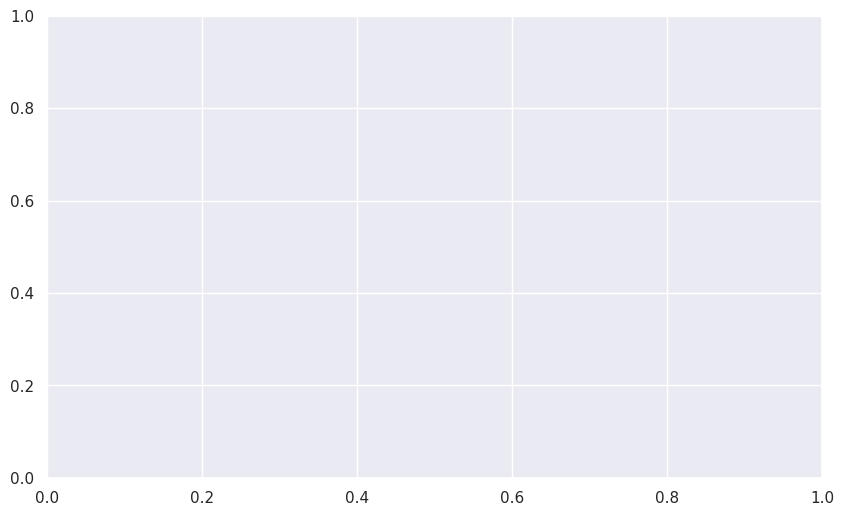

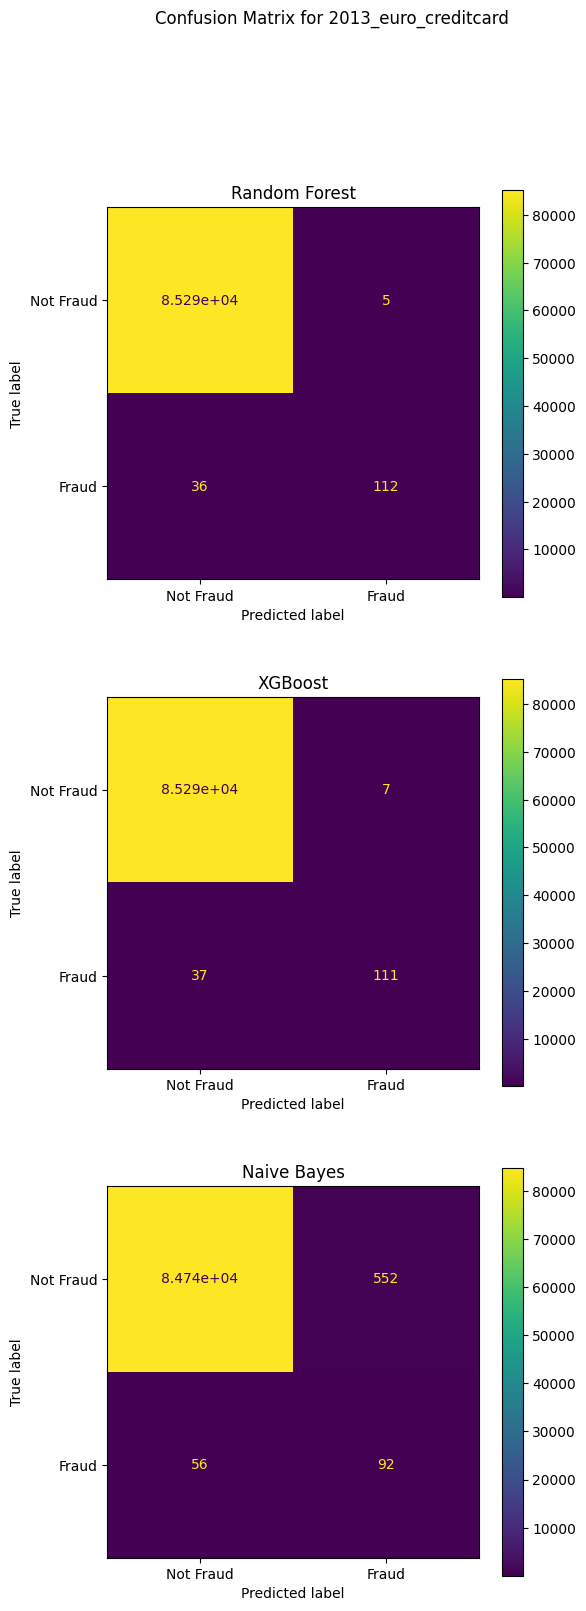

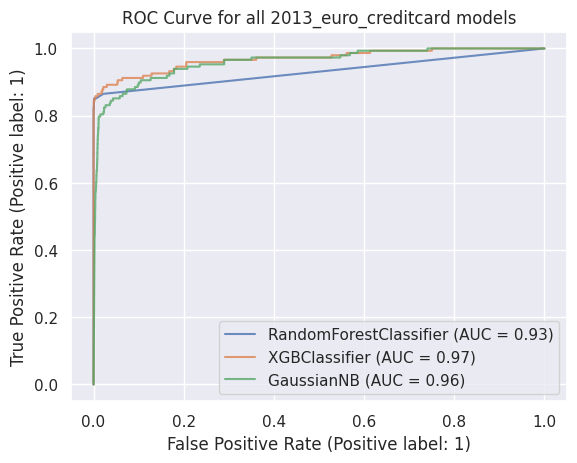

,Random Forest,XGBoost,Naive Bayes
Precision (0),0.999578,0.999566,0.999340
Precision (1),0.957265,0.940678,0.142857
Recall (0),0.999941,0.999918,0.993528
Recall (1),0.756757,0.750000,0.621622
F1-Score (0),0.999760,0.999742,0.996426
F1-Score (1),0.845283,0.834586,0.232323
Accuracy,0.999520,0.999485,0.992884


In [15]:
# Display
model_results(dataset, models, *_data, load_from_disk=True)

# TODO Comparing Models and Datasets